# Comparaison de models de machine learning

In [18]:
# Imports

import time
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    make_scorer,
)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Chemins

PROJECT_DIR = Path().cwd().parent.resolve()
DATA_DIR = PROJECT_DIR / "data"
DATA_PATH = DATA_DIR / "03_DONNEES.csv"
OUTPUT_DIR = PROJECT_DIR / "output"
PREPROCESSOR_PATH = OUTPUT_DIR / "preprocessor.pkl"

In [20]:
# Accessibilité : Daltonisme, Dyslexie, Confort Visuel

sns.set_theme(
    style="whitegrid",
    palette="colorblind",
    context="notebook",
)

plt.rcParams.update(
    {
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "font.family": "Arial",
        "font.size": 12,
        "axes.titlesize": 15,
        "axes.titleweight": "bold",
        "axes.labelsize": 13,
        "axes.labelweight": "medium",
        "axes.edgecolor": "black",
        "axes.linewidth": 1.2,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "lines.linewidth": 2.2,
        "lines.markersize": 7,
        "legend.fontsize": 11,
        "legend.frameon": True,
        "legend.framealpha": 0.95,
        "grid.linestyle": ":",
        "grid.linewidth": 0.8,
        "grid.alpha": 0.6,
    }
)

COLORBLIND_PALETTE = sns.color_palette("colorblind")

## Chargement des données et de la pipeline de prétraitement

In [21]:
df = pd.read_csv(DATA_PATH.as_posix())

X = df.drop("Churn", axis=1)
y = df["Churn"].copy()

preprocessor = joblib.load(PREPROCESSOR_PATH.as_posix())

## Split train/test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True,
)

## Définition des modèles

Pour tenir compte du déséquilibre des classes, on ajoute le paramètre `class_weight="balanced"` au modèles `LogisticRegression` et `RandomForestClassifier`. Le modèle `GradientBoostingClassifier` ne possède pas de paramètre pour contrebalancer le déséquilibre des classes.

In [23]:
models = {
    "LogisticRegression": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                LogisticRegression(random_state=42, class_weight="balanced"),
            ),
        ]
    ),
    "RandomForestClassifier": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                RandomForestClassifier(random_state=42, class_weight="balanced"),
            ),
        ]
    ),
    "GradientBoostingClassifier": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", GradientBoostingClassifier(random_state=42)),
        ]
    ),
}

## Entraînement des modèles

In [24]:
def compute_model_comparisons(
    models: dict[str, Pipeline],
) -> tuple[pd.DataFrame, dict[str, np.ndarray]]:
    """
    Entraîne et évalue plusieurs pipelines de modèles de classification,
    puis retourne un tableau comparatif des performances ainsi que les
    prédictions associées à chaque modèle.

    Pour chaque modèle fourni :
    - le pipeline est entraîné sur les données d'entraînement (X_train, y_train),
    - le temps d'entraînement est mesuré,
    - les prédictions sont générées sur X_test,
    - plusieurs métriques de classification sont calculées (Accuracy,
      Precision, Recall, F1-Score en moyenne pondérée),
    - le temps d'évaluation est affiché.

    Les variables X_train, y_train, X_test et y_test sont supposées
    définies dans l'environnement global.

    Args:
        models (dict[str, Pipeline]): Dictionnaire associant un nom de modèle
            (clé) à un objet Pipeline scikit-learn (valeur) prêt à être entraîné.

    Returns:
        tuple[pd.DataFrame, dict[str, np.ndarray]]:
            - Un DataFrame pandas contenant, pour chaque modèle :
                * Model : nom du modèle
                * Accuracy : score d'exactitude
                * Precision : précision (moyenne pondérée)
                * Recall : rappel (moyenne pondérée)
                * F1-Score : score F1 (moyenne pondérée)
                * Execution_time : temps d'entraînement en secondes
            - Un dictionnaire associant à chaque nom de modèle le tableau
              numpy des prédictions (y_pred) sur le jeu de test.
    """
    metrics = []
    predictions = {}

    for name, pipeline in models.items():
        t0 = time.time()
        pipeline.fit(X_train, y_train)
        t1 = time.time()

        print(f"Modèle {name} entraîné en {t1 - t0} secondes.")

        t2 = time.time()
        y_pred = pipeline.predict(X_test)
        predictions[name] = y_pred
        metrics.append(
            {
                "Model": name,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision Yes": precision_score(y_test, y_pred, pos_label="Yes"),
                "Precision No": precision_score(y_test, y_pred, pos_label="No"),
                "Precision Weighted": precision_score(
                    y_test, y_pred, average="weighted"
                ),
                "Recall Yes": recall_score(y_test, y_pred, pos_label="Yes"),
                "Recall No": recall_score(y_test, y_pred, pos_label="No"),
                "Recall Weighted": recall_score(y_test, y_pred, average="weighted"),
                "F1 Yes": f1_score(y_test, y_pred, pos_label="Yes"),
                "F1 No": f1_score(y_test, y_pred, pos_label="No"),
                "F1 Weighted": f1_score(y_test, y_pred, average="weighted"),
                "Time": t1 - t0,
            }
        )
        t3 = time.time()

        print(f"Modèle {name} évalué en {t3 - t2} secondes.")

    return pd.DataFrame(metrics), predictions


metrics, predictions = compute_model_comparisons(models)

Modèle LogisticRegression entraîné en 0.04863691329956055 secondes.
Modèle LogisticRegression évalué en 0.03874039649963379 secondes.
Modèle RandomForestClassifier entraîné en 0.42188167572021484 secondes.
Modèle RandomForestClassifier évalué en 0.04792380332946777 secondes.
Modèle GradientBoostingClassifier entraîné en 0.7698483467102051 secondes.
Modèle GradientBoostingClassifier évalué en 0.03671884536743164 secondes.


## Sélection du meilleur modèle

In [25]:
metrics.sort_values("Recall Yes", ascending=False).head()

,Model,Accuracy,Precision Yes,Precision No,Precision Weighted,Recall Yes,Recall No,Recall Weighted,F1 Yes,F1 No,F1 Weighted,Time
0,LogisticRegression,0.634493,0.224382,0.909846,0.811088,0.625616,0.635987,0.634493,0.330299,0.748658,0.688383,0.048637
2,GradientBoostingClassifier,0.853797,0.428571,0.860231,0.798040,0.044335,0.990050,0.853797,0.080357,0.920586,0.799531,0.769848
1,RandomForestClassifier,0.851668,0.312500,0.857861,0.779289,0.024631,0.990879,0.851668,0.045662,0.919584,0.793675,0.421882


Observations :
- Le modèle `LogisticRegression` a une *accuracy* faible $\simeq 0.63$. Sa *precision* $\simeq 0.22$ montre qu'il produit beaucoup de faux positif. Son *recall* $\simeq 0.63$ indique qu'il détecte le Churn. Son *Fi score* $\simeq 0.33$ est significativement meilleur que celui des autres modèles. En résumé, ce modèle privilégie le *recall* au détriment de la *precision*.
- Les modèles `RandomForestClassifier` et `GradientBoostingClassifier` ont une *accuracy* élevée $\simeq 0.85$. Leur *precision* $\simeq 0.3 - 0.4$ montre qu'ils produisent moins de faux positif que le modèle `LogisticRegression`. Leur *recall* $\simeq 0.02 - 0.04$ indique qu'il ne détecte pas le Churn. En résumé, ces modèles sont biaisé vers la classe majoritaire.
- On remarque que le modèle `LogisticRegression` est bien plus rapide que les autres.

Conclusion :
- Le meilleur modèle semble être `LogisticRegression` car il détecte le Churn. Cependant il faudra veiller à minimiser le nombre de faux positifs. L'optimisation du modèle visera un compromis *precision*/*recall*.

## Evaluation du meilleur modèle

In [26]:
best_model_name = "LogisticRegression"
best_model = models[best_model_name]

y_pred = best_model.predict(X_test)

In [27]:
print(f"Rapport de classification ({best_model_name})")
print(classification_report(y_test, y_pred))

Rapport de classification (LogisticRegression)
              precision    recall  f1-score   support

          No       0.91      0.64      0.75      1206
         Yes       0.22      0.63      0.33       203

    accuracy                           0.63      1409
   macro avg       0.57      0.63      0.54      1409
weighted avg       0.81      0.63      0.69      1409



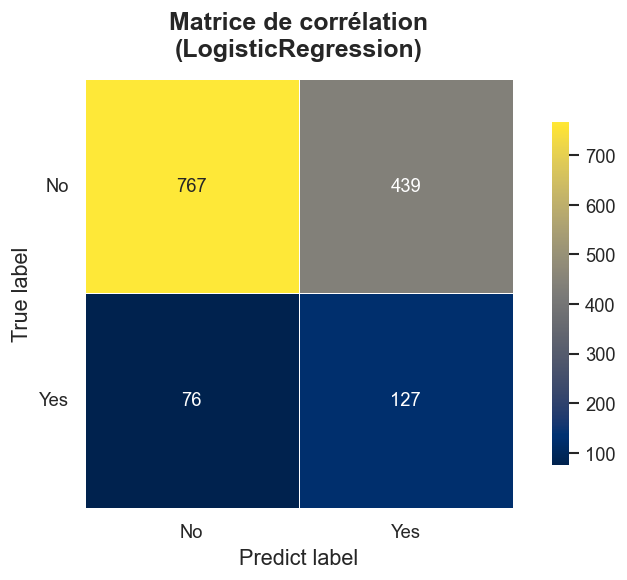

In [28]:
fig, ax = plt.subplots(figsize=(7, 5))

sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt=".0f",
    cmap="cividis",
    square=True,
    linewidths=0.6,
    linecolor="white",
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 11},
    ax=ax,
)
ax.set_title(f"Matrice de corrélation\n({best_model_name})", pad=14)
ax.set_xlabel("Predict label")
ax.set_ylabel("True label")
ax.set_xticklabels(["No", "Yes"])
ax.set_yticklabels(["No", "Yes"], rotation=0)

plt.tight_layout()
plt.show()

In [29]:
scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, pos_label="Yes"),
    "recall": make_scorer(recall_score, pos_label="Yes"),
    "f1": make_scorer(f1_score, pos_label="Yes"),
}

results = cross_validate(
    best_model,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring,
    return_train_score=True,
)

In [31]:
print("Cross Validation (StratifiedKFold(n_splits=5, shuffle=True)) :")
print(
    f"  Train accuracy : {results['train_accuracy'].mean():.4f} (+/- {results['train_accuracy'].std():.4f})"
)
print(
    f"  Test accuracy : {results['test_accuracy'].mean():.4f} (+/- {results['test_accuracy'].std():.4f})"
)
print(
    f"  Test F1 : {results['test_f1'].mean():.4f} (+/- {results['test_f1'].std():.4f})"
)
print(
    f"  Test précision : {results['test_precision'].mean():.4f} (+/- {results['test_precision'].std():.4f})"
)
print(
    f"  Test recall : {results['test_recall'].mean():.4f} (+/- {results['test_recall'].std():.4f})"
)
print(f"  Time : {results['fit_time'].mean():.4f}")

Cross Validation (StratifiedKFold(n_splits=5, shuffle=True)) :
  Train accuracy : 0.6411 (+/- 0.0031)
  Test accuracy : 0.6342 (+/- 0.0069)
  Test F1 : 0.3417 (+/- 0.0057)
  Test précision : 0.2305 (+/- 0.0039)
  Test recall : 0.6605 (+/- 0.0175)
  Time : 0.0288


Observations :
- La validation croisée confirme que le modèle `LogisticRegression` a une *accuracy* faible, une *precision* très faible mais un bon *recall*.
- Les écart-types montre une faible variabilité indiquant une bonne stabilité du modèle.
- La différence entre l'accuracy du jeu d'entraînement et celle du jeu de test est très faible, ce qui montre l'absence d'overfitting. Cependant la faible accuracy pourrait indique de l'underfitting.